#### Scraping Our Data

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def scraper(base_url: str, start_page: str, end_page: str) -> pd.DataFrame:
    reviews = []

    for page_num in range(start_page, end_page + 1):
        url = f"{base_url}/page/{page_num}/?sortby=post_date%3ADesc&pagesize=100"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        review_elements = soup.find_all('article', itemprop='review')

        for element in review_elements:
            review_data = {}

            # Define the verification status based on the presence of specific text
            if "✅ Trip Verified" in element.get_text():
                review_data['verification_status'] = "Trip Verified"
            elif "✅ Verified Review" in element.get_text():
                review_data['verification_status'] = "Review Verified"
            else:
                review_data['verification_status'] = "Not Verified"

            # Clean review body text
            review_body = element.find('div', class_='text_content').get_text(strip=True)
            review_body = review_body.replace("✅Trip Verified|", "").replace("✅Verified Review|", "").replace("Not Verified|", "").strip()
            review_data['review_body'] = review_body

            # Extract published date
            published_date = element.find('time', itemprop='datePublished')['datetime']
            review_data['published_date'] = published_date

            # Extract rating
            rating_element = element.find('div', itemprop='reviewRating')
            if rating_element:
                rating_value = rating_element.find('span', itemprop='ratingValue').get_text(strip=True)
                best_rating = rating_element.find('span', itemprop='bestRating').get_text(strip=True)
                review_data['rating'] = f"{rating_value}/{best_rating}"

            # Extract additional data
            rows = element.find_all('tr')
            for row in rows:
                header = row.find('td', class_='review-rating-header')
                value = row.find('td', class_='review-value')
                if header and value:
                    review_data[header.get_text(strip=True)] = value.get_text(strip=True)

            reviews.append(review_data)

    df = pd.DataFrame(reviews)
    return df

# Define the base URL and page range
base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'
start_page = 1
end_page = 40

# Scrape the reviews
reviews_df = scraper(base_url, start_page, end_page)

print(reviews_df)


     verification_status                                        review_body  \
0           Not Verified  Very good flight following an equally good fli...   
1           Not Verified  An hour's delay due to late arrival of the inc...   
2          Trip Verified  I booked through BA because Loganair don’t hav...   
3          Trip Verified  British airways lost bags in LHR then found th...   
4          Trip Verified  The check in process and reward/loyalty progra...   
...                  ...                                                ...   
3906        Not Verified  Flew return in CW from LHR to BKK in August 20...   
3907        Not Verified  LHR to HAM. Purser addresses all club passenge...   
3908        Not Verified  My son who had worked for British Airways urge...   
3909        Not Verified  London City-New York JFK via Shannon on A318 b...   
3910        Not Verified  SIN-LHR BA12 B747-436 First Class. Old aircraf...   

     published_date rating Aircraft Type Of Travell

In [96]:
# save this data to the raw data folder
reviews_df.to_parquet('../data/raw/past_reviews.parquet')

In [46]:
# make sure we can read it in
reviews_df = pd.read_parquet('../data/raw/past_reviews.parquet')

In [97]:
reviews_df.head()

,verification_status,review_body,published_date,rating,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9/10,A320,Solo Leisure,Business Class,London Heathrow to Zurich,January 2025,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7/10,A319,Family Leisure,Economy Class,London to Lisbon,January 2025,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1/10,NaN,Solo Leisure,Economy Class,Manchester to Isle of Man,November 2024,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1/10,NaN,Family Leisure,Premium Economy,Houston to cologne via London,December 2024,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1/10,A320,Business,Economy Class,London to Basel,January 2025,no


### EDA 

It appears that all of our data are **object** types but the rating should be a numeric value. We also see that some of the columns are capital and include spaces from when we scraped the data table and the variables we created are lowercase with underscores so we can change them to a standard format.

In [98]:
# function to rename columns
def rename_cols(reviews_df: pd.DataFrame) -> pd.DataFrame:
    '''Change column names to snake case.'''
    return reviews_df.rename(columns={
        'Aircraft': 'aircraft',
        'Type Of Traveller': 'type_of_traveler', 
        'Seat Type': 'seat_type', 
        'Route': 'route', 
        'Date Flown': 'date_flown', 
        'Recommended': 'recommended'},
        inplace=True
)

In [99]:
# rename the columns using the function
rename_cols(reviews_df)

In [100]:
# check they have been renamed
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   verification_status  3911 non-null   object
 1   review_body          3911 non-null   object
 2   published_date       3911 non-null   object
 3   rating               3906 non-null   object
 4   aircraft             2037 non-null   object
 5   type_of_traveler     3140 non-null   object
 6   seat_type            3909 non-null   object
 7   route                3135 non-null   object
 8   date_flown           3133 non-null   object
 9   recommended          3911 non-null   object
dtypes: object(10)
memory usage: 305.7+ KB


In [101]:
reviews_df.describe()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
count,3911,3911,3911,3906,2037,3140,3909,3135,3133,3911
unique,3,3896,1981,10,212,4,4,1633,126,2
top,Not Verified,British Airways from Tampa to Gatwick on Boein...,2015-01-19,1/10,A320,Couple Leisure,Economy Class,London to Johannesburg,August 2015,no
freq,1837,2,26,951,394,1057,2038,21,83,2354


The **review_body** column has 3911 reviews but only 3896 unique values meaning we have duplicates. We can inspect and remove them.

In [102]:
# find the duplicate reviews and inspect them
duplicate_review_body = reviews_df[reviews_df.duplicated(subset=['review_body'], keep=False)]
duplicate_review_body.sort_values('review_body')

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
3596,Not Verified,BA26 22/6/2014. During my trip to the UK I fee...,2014-10-05,7/10,NaN,NaN,Economy Class,NaN,NaN,yes
3603,Not Verified,BA26 22/6/2014. During my trip to the UK I fee...,2014-10-05,7/10,NaN,NaN,Economy Class,NaN,NaN,yes
3400,Not Verified,BA284 Dec 29 2014. SFO-LHR First. Great flight...,2015-01-19,10/10,NaN,NaN,First Class,NaN,NaN,yes
3393,Not Verified,BA284 Dec 29 2014. SFO-LHR First. Great flight...,2015-01-19,10/10,NaN,NaN,First Class,NaN,NaN,yes
2739,Not Verified,British Airways from Tampa to Gatwick on Boein...,2015-12-01,8/10,Boeing 777,Couple Leisure,Business Class,Tampa to Gatwick,November 2015,yes
2767,Not Verified,British Airways from Tampa to Gatwick on Boein...,2015-11-20,8/10,Boeing 777,Couple Leisure,Business Class,Tampa to Gatwick,November 2015,yes
3200,Not Verified,CPT-LHR-MAD in club. Check-in in CPT quick and...,2015-05-16,9/10,NaN,NaN,Business Class,NaN,NaN,yes
3199,Not Verified,CPT-LHR-MAD in club. Check-in in CPT quick and...,2015-05-16,9/10,NaN,NaN,Business Class,NaN,NaN,yes
3604,Not Verified,Flew the new 787 Business Class from PHI to LH...,2014-10-05,6/10,NaN,NaN,Business Class,NaN,NaN,no
3597,Not Verified,Flew the new 787 Business Class from PHI to LH...,2014-10-05,6/10,NaN,NaN,Business Class,NaN,NaN,no


In [104]:
print(len(duplicate_review_body))

30


When we check the duplicates for the entire dataset we are getting a number smaller (26) than our number for the reviews (30). After inspection, we see that these reviews came in on different dates so that is the reason there are less for the entire dataset. Having a different date posted causes them not to be duplicates. We will remove the duplicates and keep the one with the oldest date. When we scraped the data we were using their filter which had them sorted by date from newest to oldest so we will sort them from oldest to newest to keep the oldest duplicate.

In [105]:
# Identify duplicate rows based on the entire dataset
duplicate_rows = reviews_df[reviews_df.duplicated(keep=False)]

# Display the duplicate rows
print(len(duplicate_rows))


26


In [106]:
# remove duplicates and keep the oldest review - sort by published date
reviews_df['published_date'] = pd.to_datetime(reviews_df['published_date'])
# sort by published date
reviews_df.sort_values('published_date', inplace=True)
# remove duplicates
reviews_df.drop_duplicates(subset='review_body', keep='first', inplace=True)


In [107]:
# now there should be 3904 reviews since there were 3904 unique reviews
len(reviews_df)

3896

In [108]:
# sort by published date with most recent being first
reviews_df.sort_values('published_date', ascending=False, inplace=True) 
reviews_df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9/10,A320,Solo Leisure,Business Class,London Heathrow to Zurich,January 2025,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7/10,A319,Family Leisure,Economy Class,London to Lisbon,January 2025,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1/10,NaN,Solo Leisure,Economy Class,Manchester to Isle of Man,November 2024,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1/10,NaN,Family Leisure,Premium Economy,Houston to cologne via London,December 2024,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1/10,A320,Business,Economy Class,London to Basel,January 2025,no


In [109]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3896 entries, 0 to 3910
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   verification_status  3896 non-null   object        
 1   review_body          3896 non-null   object        
 2   published_date       3896 non-null   datetime64[ns]
 3   rating               3891 non-null   object        
 4   aircraft             2035 non-null   object        
 5   type_of_traveler     3138 non-null   object        
 6   seat_type            3894 non-null   object        
 7   route                3133 non-null   object        
 8   date_flown           3131 non-null   object        
 9   recommended          3896 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 334.8+ KB


In [110]:
reviews_df.describe(include='all')

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
count,3896,3896,3896,3891,2035,3138,3894,3133,3131,3896
unique,3,3896,NaN,10,212,4,4,1633,126,2
top,Not Verified,SIN-LHR BA12 B747-436 First Class. Old aircraf...,NaN,1/10,A320,Couple Leisure,Economy Class,London to Johannesburg,August 2015,no
freq,1822,1,NaN,949,394,1055,2035,21,83,2349
mean,NaN,NaN,2018-02-02 17:50:23.408624128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2011-10-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2015-09-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2017-04-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2019-09-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The rating column are reviews based on a scale from 1-10 so we can convert this to a numeric value, however, there are some missing values (5) so we will have to check these out first.

#### Rating Variable

In [111]:
# Filter the DataFrame to find rows with NaN values in the 'review' column
nan_reviews = reviews_df[reviews_df['rating'].isna()]
nan_reviews

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
3336,Not Verified,Cabin crew polite unfortunately BA ran out of ...,2015-02-18,NaN,NaN,NaN,Economy Class,NaN,NaN,no
3465,Not Verified,Phoenix to London - outbound a wonderful and e...,2014-12-10,NaN,NaN,NaN,First Class,NaN,NaN,no
3479,Not Verified,On past experience I chose BA for our long hau...,2014-11-25,NaN,NaN,NaN,Economy Class,NaN,NaN,no
3718,Not Verified,LHR-CPH-LHR Business Class. This is a joke. Sc...,2014-07-31,NaN,NaN,NaN,Business Class,NaN,NaN,no
3752,Not Verified,I flew with British Airways with my mother fro...,2014-07-15,NaN,NaN,NaN,Economy Class,NaN,NaN,no


Although there are NaN values for the following 5 reviews we can see that they are all bad reviews. This means we can inpute a value here knowing that the review would not be plesent. Looking at the **value_counts** for the ratings most ratings are 1/10 and these ratings seem to fit a 1/10 rating as well so we will impute that value for them.

In [112]:
for review in nan_reviews['review_body']:
    print(f'{review}\n')

Cabin crew polite unfortunately BA ran out of chicken ran out of wine ran out of soft drinks. The food was awful. Inflight service was a disaster - did not work properly. 12 hours 20 mins flight everything counts obviously BA overlooked this. To be fair all cabin crew were polite and accommodating. I will never fly again with BA.

Phoenix to London - outbound a wonderful and enjoyable experience. The problem we had started on our return flight home. We boarded the plane and were disappointed to find out that we were in the old style first class. After being in the new cabin on the way out the old configuration is very run down and there was a rip in the seat. I was attempting to work but when I went to plug in my laptop battery I found that there was no adapter for me to use. Since I could no longer work I decided to put a movie on. The tiny screen in the old first class was just pathetic. The flight attendants did their absolute best to make up for the issues and I give them high mark

In [113]:
reviews_df['rating'].value_counts()

rating
1/10     949
2/10     444
3/10     429
8/10     385
10/10    334
9/10     323
7/10     321
4/10     262
5/10     243
6/10     201
Name: count, dtype: int64

In [114]:
# fill the empty ratings with a 1/10
reviews_df['rating'] = reviews_df['rating'].fillna('1/10')

In [115]:
# no more missing values
reviews_df[reviews_df['rating'].isna()]

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended


In [116]:
reviews_df['rating'].value_counts()

rating
1/10     954
2/10     444
3/10     429
8/10     385
10/10    334
9/10     323
7/10     321
4/10     262
5/10     243
6/10     201
Name: count, dtype: int64

In [117]:
# Function to convert rating to float
def convert_rating(rating: str) -> float:
    '''Convert rating to float.'''
    # Split the string on '/' and take the first part
    numerator = rating.split('/')[0]  
    return float(numerator)

# Apply the function to the 'rating' column
reviews_df['rating'] = reviews_df['rating'].apply(convert_rating)

reviews_df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9.0,A320,Solo Leisure,Business Class,London Heathrow to Zurich,January 2025,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7.0,A319,Family Leisure,Economy Class,London to Lisbon,January 2025,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,NaN,Solo Leisure,Economy Class,Manchester to Isle of Man,November 2024,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,NaN,Family Leisure,Premium Economy,Houston to cologne via London,December 2024,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,London to Basel,January 2025,no


In [119]:
(reviews_df['rating']).describe()

count    3896.000000
mean        4.664271
std         3.175115
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        10.000000
Name: rating, dtype: float64

In [121]:
# scatter plot of rating and published date
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# use plotly for the time series plot
fig = px.scatter(reviews_df, x='published_date', y='rating', title='Rating over Time')
fig.show()



#### Verification Status

In [122]:
reviews_df[reviews_df['verification_status'] == 'Verified Review']

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended


In [123]:
reviews_df['review_body'][2558]

'British Airways from Seattle to Johannesburg via London Heathrow. First leg SEA to LHR was on a 747. The plane was satisfactory to me. I don\'t understand the comments from people who think the 747 is tired or worn out. Not a bad ride in economy when the person in front of you doesn\'t recline their seat. I sat in one of the "twosomes" (seat 52A) in the tail. The food on this leg was bland, the continental breakfast was a disappointment. I would buy seat 52A again if I was traveling on a British Airways 747, but be advised there is no wall next to 52A that you can lean on to sleep. Second leg was on an A380. I sat in the tail of the upper deck in seat 82A. This time, the young woman in front of me reclined to the maximum as soon as she could and kept her seat that way the entire 11+ hours of the flight. The A380 is a very nice plane and the overall experience was pleasant despite extensive turbulence the majority of the way. The upper cabin on an A380 is amazingly quiet. The food on t

In [124]:
verified_reviews_df = reviews_df[reviews_df['review_body'].str.startswith("✅Verified Review|", na=False)]
verified_reviews_df 

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended


In [70]:
reviews_df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9.0,A320,Solo Leisure,Business Class,London Heathrow to Zurich,January 2025,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7.0,A319,Family Leisure,Economy Class,London to Lisbon,January 2025,yes
2,Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,None,Solo Leisure,Economy Class,Manchester to Isle of Man,November 2024,no
3,Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,None,Family Leisure,Premium Economy,Houston to cologne via London,December 2024,no
4,Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,London to Basel,January 2025,no


In [71]:
reviews_df.tail()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
3904,Not Verified,YYZ to LHR - July 2012 - I flew overnight in p...,2012-08-29,8.0,None,None,Premium Economy,None,None,yes
3907,Not Verified,LHR to HAM. Purser addresses all club passenge...,2012-08-28,9.0,None,None,Business Class,None,None,yes
3908,Not Verified,My son who had worked for British Airways urge...,2011-10-12,5.0,None,None,Economy Class,None,None,yes
3909,Not Verified,London City-New York JFK via Shannon on A318 b...,2011-10-11,4.0,None,None,Premium Economy,None,None,no
3910,Not Verified,SIN-LHR BA12 B747-436 First Class. Old aircraf...,2011-10-09,4.0,None,None,First Class,None,None,no


In [125]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3896 entries, 0 to 3910
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   verification_status  3896 non-null   object        
 1   review_body          3896 non-null   object        
 2   published_date       3896 non-null   datetime64[ns]
 3   rating               3896 non-null   float64       
 4   aircraft             2035 non-null   object        
 5   type_of_traveler     3138 non-null   object        
 6   seat_type            3894 non-null   object        
 7   route                3133 non-null   object        
 8   date_flown           3131 non-null   object        
 9   recommended          3896 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 463.9+ KB


In [ ]:
# plot the ratings by year
reviews_df['year'] = reviews_df['published_date'].dt.year
reviews_df['month'] = reviews_df['published_date'].dt.month
reviews_df['day'] = reviews_df['published_date'].dt.day


In [ ]:
def yearly_avg(df: pd.DataFrame) -> pd.Series:
    return df.groupby('year')['rating'].mean()

<Axes: title={'center': 'Average Rating by Year'}, xlabel='year'>

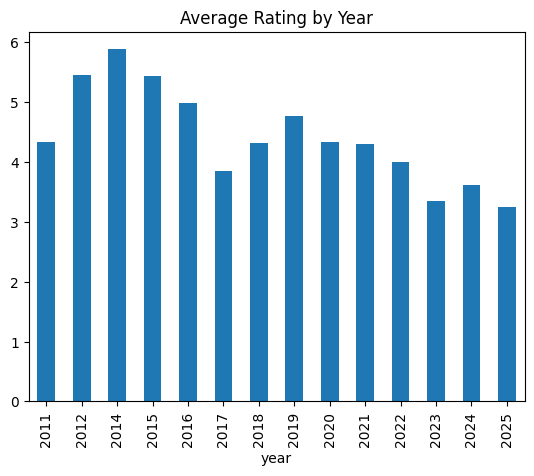

In [130]:
yearly_avg(reviews_df).plot(kind='bar', title='Average Rating by Year')